# Starting by building the game and the user interface

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Initial thoughts: Have an set of actions to choose from. i.e the available board positions and either randomly pick one or choose the one that provided the best reward in the past. This means we need to define rewards for each individual placements. But we are not taking into account the temporal element as well as the rest of the board. Is this important? I would think so. Or is there a list of optimal positions in descending order so if one is chosen then choose the next best in the list.

#### Other option is to have a reward for each game: Then each set of moves made by the agent is rated. The reward per each move is then summed up and you get the distribution for each move. Then the agent can select the best moves based on the rewards.  

#### This also means I have to play thousands of games to teach the agent. Otherwise I have to create a good expert. We could have an expert that plays a specific game

In [2]:
def showBoard():
    '''Shows the board'''
    for val in board:
        print(val)

def checkFree(x,y):
    '''Takes an x,y postion and checks if that point on the board is free'''
    if board[x,y] ==0:
        return True
    else:
        return False
def checkWin(toggle):
    '''checks wins for each player for diagonals, rows, columns'''
    if toggle:
        high = 6
    else:
        high = 15
    if board.diagonal().sum() == high:
        return True
    if np.flip(board,1).diagonal().sum() == high:
        return True
    for val in range(0,3):
        if board[val,:].sum()==high:
            return True
    for val in range(0,3):
        if board[:,val].sum()==high:
            return True
    return False

def getAvailablePositions():
    pos = []
    for i in range(3):
        for j in range(3):
            if checkFree(i,j):
                pos.append([i,j])
    return pos

def placePiece(x,y,nought_or_cross):
    '''Takes a x, y position and a X or O with X=1, and O=2'''
    board[x,y] = nought_or_cross

In [3]:
def init():
    '''Initilizes the q-values'''
    q_val = {}
    n_val = {}
    moves = [[0,1],[0,2],[1,2],[2,2],[2,1],[0,0],[1,0],[1,1],[2,0]]
    for val in moves:
        q_val[str(val)]=0
    for val in moves:
        n_val[str(val)]=0
    return q_val,n_val

def predict(avail_moves,epsilon,q_val):
    '''Takes the available moves, epsilon and q_values
        Chooses a random move from the available moves if the random number is higher than epsilon. 
        Chooses the available move which has the highest q_val 
        Returns the move chosen
    '''
    ran_num = np.random.rand()
    if ran_num > epsilon:
        return avail_moves[np.random.randint(len(avail_moves))]
    else:
        max = q_val[str(avail_moves[0])]
        for val in avail_moves:
            if q_val[str(val)]>=max:
                max = q_val[str(val)]
                best = val
        return best

def updateQValues(movesPerformed,q_val,reward, n_values):
    '''Updates q-values using the old q_vals, rewards and gameNum'''
    for move in movesPerformed:
        n = n_values[str(move)]
        q_val[str(move)] = ((n-1)/float(n))*q_val[str(move)]+reward*(1/float(n))
    return q_val

def updateNValues(movesPerformed,n_val):
    '''Updates q-values using the old n_vals, rewards and gameNum'''
    for move in movesPerformed:
        n_val[str(move)] = n_val[str(move)]+1
    return n_val

def reward(result,num_moves):
    '''Reward a game won or lost'''
    if result == 'lost':
        return -10+(-num_moves)
    elif result== 'win':
        return 10+(-num_moves)
    else:
        return 0+(-num_moves)

def chooseEpsilon(epoch):
    return 1-np.exp(-epoch/10)

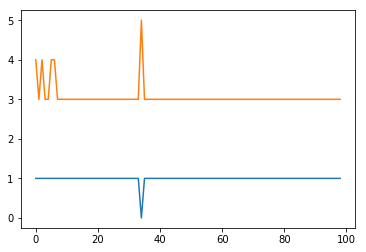

In [7]:
#run function
q_values, n_values = init()
num_wins = []
num_moves_per_game = []

for epoch in range(1,100):
    
    toggle = False
    board = np.zeros((3,3))
    #bad_expert = [[0,1],[0,2],[1,2],[2,2],[2,1],[0,0],[1,0],[1,1],[2,0]]
    expert = [[1,1],[0,2],[2,0],[2,2],[0,0],[0,1],[1,0],[1,2],[2,1]]
    count = 0
    moves = []
    epsilon = chooseEpsilon(epoch)
    
    while True:
        toggle = not toggle
        if toggle:
            move = predict(getAvailablePositions(),epsilon,q_values)
            x = move[0]
            y = move[1]
            moves.append(move)
        else:
            x = expert[count][0]
            y = expert[count][1]
            count = count+1
            while not checkFree(x,y):
                x = expert[count][0]
                y = expert[count][1]
                count = count+1
        if toggle == True:
            n_or_c = 5
        else:
            n_or_c = 2
        placePiece(int(x),int(y),n_or_c)
        if checkWin(toggle):
            result = 'lost'
            winner = -1
            break
        elif checkWin(not toggle):
            result = 'win'
            winner = 1
            break
        elif not getAvailablePositions():
            result = 'draw'
            winner = 0
            break
    n_values = updateNValues(moves,n_values)
    q_values = updateQValues(moves,q_values, reward(result, len(moves)),n_values)
    num_wins.append(winner)
    num_moves_per_game.append(len(moves))
    
plt.plot(num_wins)
plt.plot(num_moves_per_game)

### The q-values stabilize after about 35 runs. 

In [8]:
q_values

{'[0, 0]': 5.333333333333333,
 '[0, 1]': 6.5,
 '[0, 2]': 3.25,
 '[1, 0]': 6.6,
 '[1, 1]': 0,
 '[1, 2]': 4.2,
 '[2, 0]': 6.983606557377046,
 '[2, 1]': 6.861702127659572,
 '[2, 2]': 6.978021978021975}

In [9]:
#test function

for epoch in range(1,2):
    
    toggle = False
    board = np.zeros((3,3))
    #bad_expert = [[0,1],[0,2],[1,2],[2,2],[2,1],[0,0],[1,0],[1,1],[2,0]]
    expert = [[1,1],[0,2],[2,0],[2,2],[0,0],[0,1],[1,0],[1,2],[2,1]]
    count = 0
    moves = []
    epsilon = chooseEpsilon(epoch)
    
    while True:
        toggle = not toggle
        #print(toggle)
        showBoard()
        if toggle:
            print('agent moves')
            move = predict(getAvailablePositions(),1,q_values)
            x = move[0]
            y = move[1]
            moves.append(move)
        else:
            print('expert moves')
            x = expert[count][0]
            y = expert[count][1]
            count = count+1
            while not checkFree(x,y):
                x = expert[count][0]
                y = expert[count][1]
                count = count+1
        if toggle == True:
            n_or_c = 5
        else:
            n_or_c = 2
        placePiece(int(x),int(y),n_or_c)
        if checkWin(toggle):
            print('2 has won!')
            winner = 0
            break
        elif checkWin(not toggle):
            winner = 1
            print('5 has won!')
            break
        elif not getAvailablePositions():
            print('draw')
            winner = -1
            break
    
    showBoard() 


[ 0.  0.  0.]
[ 0.  0.  0.]
[ 0.  0.  0.]
agent moves
[ 0.  0.  0.]
[ 0.  0.  0.]
[ 5.  0.  0.]
expert moves
[ 0.  0.  0.]
[ 0.  2.  0.]
[ 5.  0.  0.]
agent moves
[ 0.  0.  0.]
[ 0.  2.  0.]
[ 5.  0.  5.]
expert moves
[ 0.  0.  2.]
[ 0.  2.  0.]
[ 5.  0.  5.]
agent moves
5 has won!
[ 0.  0.  2.]
[ 0.  2.  0.]
[ 5.  5.  5.]


### The agent now plays the win in 3 moves. The q-values decide how fast it wins. It can vary from 3-4 from what i've seen. Of course the multiple trials are pointless because the q_values aren't changing over time. It would be interesting to see how the number of moves reduce over time when it is training. 

### Improvements will be to make a better expert, to test how much the agent can learn. The expert currently has not very good behavior. If we make the expert one that has a plan, will the agent be able to learn couteractive behavior. 